In [179]:
import torch
from torch import nn
import numpy as np
import os
class FacePredict(nn.Module):
    def __init__(self):
        """
        Initialize using a pretrained tf model
        """
        super().__init__()
        self.lstm = nn.LSTM(28, 60)
        self.dropout = nn.Dropout(p=0.7)
        self.dense = nn.Linear(60, 20)
        
    def forward(self, inputs):
        hid0, _ = self.lstm(inputs)
        hiddrop = self.dropout(hid0)
        return self.dense(hid0)
    
    def load_weights_tf(self):
        #get the weights from tf model
        with torch.no_grad():
            #reorder weights to convert from tf to torch
            wii, wic, wif, wio = np.split(weights[2][:28, :], 4, 1)
            whi, whc, whf, who = np.split(weights[2][28:, :], 4, 1)
            wih = np.concatenate((wii, wif, wic, wio), axis = 1)
            whh = np.concatenate((whi, whf, whc, who), axis = 1)

            self.lstm.weight_ih_l0.data = torch.from_numpy(wih).transpose(0,1)
            self.lstm.weight_hh_l0.data = torch.from_numpy(whh).transpose(0,1)
            self.lstm.bias_hh_l0.data = torch.from_numpy(weights[3])
            self.lstm.bias_ih_l0.data = torch.zeros((240))

            self.dense.weight.data = torch.from_numpy(weights[0].T)
            self.dense.bias.data = torch.from_numpy(weights[1])


In [117]:
def get_audio_derivatives(audio):
    #calculate audio derivatives, return timestamps too
    audiodiff = audio[1:,:-1] - audio[:-1, :-1]
    times = audio[:, -1]
    return np.concatenate((audio[:-1, :-1], audiodiff[:, :]), axis=1), times

def shifted_time(i, times):
      if i >= 20:
        return times[i - 20]
      else:
        return times[0]

In [119]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
person = 'trump'
dataset_name = {'obama':'nHREBzHqFTQ', 'trump':'xAAmF3H0-ek'}[person]

In [ ]:
audio_preprocessed = np.load(f'/content/drive/MyDrive/6869/{dataset_name}_audio.npy')
audio_data = get_audio_derivatives(audio_preprocessed)[0]
print(audio_data.shape)
audio_mean = audio_data.mean(axis = 0)
audio_std = audio_data.std(axis = 0)

(57190, 28)


In [180]:
class FacePredictFineTune(FacePredict):
    def __init__(self, mean, std):
        super().__init__()
        self.dense_input = nn.Linear(28, 28, bias = False)
        self.dense_diff = nn.Linear(60, 20, bias = False)

        nn.init.zeros_(self.dense_input.weight)
        
        nn.init.xavier_uniform_(self.dense_diff.weight)
        
        self.bn = nn.BatchNorm1d(28) #not used
        self.mean = torch.from_numpy(mean).requires_grad_(False)
        self.std = torch.from_numpy(std).requires_grad_(False)

    def forward(self, inputs):
        #shape T*B*D (time*batch*num_feat)
        inputs_transformed = inputs# + self.dense_input(inputs)/10
        inputs_norm = (inputs_transformed - self.mean[None, None, :]) / self.std[None, None, :]
        hid0, _ = self.lstm(inputs_norm)
        hiddrop = self.dropout(hid0)
        return self.dense(hid0) # +self.dense_diff(hid0)

    def cuda(self):
        super().cuda()
        self.mean, self.std = self.mean.cuda(), self.std.cuda()

In [181]:
model = FacePredictFineTune(audio_mean, audio_std)
model.load_state_dict(torch.load('/content/drive/MyDrive/6869/face predict'))
model.double()
model.cuda()
model.train()
#torch.save(fpf.state_dict(), 'face predict')

FacePredictFineTune(
  (lstm): LSTM(28, 60)
  (dropout): Dropout(p=0.7, inplace=False)
  (dense): Linear(in_features=60, out_features=20, bias=True)
  (dense_input): Linear(in_features=28, out_features=28, bias=False)
  (dense_diff): Linear(in_features=60, out_features=20, bias=False)
  (bn): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [ ]:
video_data = np.load(f'/content/drive/MyDrive/6869/{dataset_name}_landmarks_frontalized.npy').reshape(-1, 25, 2)
video_lip_fiducials = video_data[:, 5:].reshape(-1, 40)
video_lip_fiducials = video_lip_fiducials[:, list(range(24)) + list(range(26,32)) + list(range(34,40))]
video_lip_fiducials.shape

(16947, 36)

In [ ]:
#crop and shift of video, in seconds
start_frame = {'obama': 303, 'trump': 12}[person]
end_frame = {'obama': 6103, 'trump': 16959}[person]
video_start = start_frame*100//30 #12
video_end = (end_frame - 1)*100//30 #inclusive 16958
video_shft = 20
video_start

40

In [186]:
#preprocess video using pca
from sklearn.decomposition import PCA
pca = PCA(n_components = 20)
lip_features = pca.fit_transform(video_lip_fiducials)

#upsampling
from scipy.interpolate import interp1d
video_times = np.arange(start_frame, end_frame)/30
lips_interpolate = interp1d(video_times, lip_features, axis = 0)
audio_times = np.arange(video_start, video_end)/100
lips_upsampled = lips_interpolate(audio_times)

['n_components', 'copy', 'whiten', 'svd_solver', 'tol', 'iterated_power', 'random_state', '_fit_svd_solver', 'mean_', 'n_samples_', 'n_features_', 'components_', 'n_components_', 'explained_variance_', 'explained_variance_ratio_', 'singular_values_', 'noise_variance_', '__module__', '__doc__', '__init__', 'fit', 'fit_transform', '_fit', '_fit_full', '_fit_truncated', 'score_samples', 'score', '__abstractmethods__', '_abc_impl', 'get_covariance', 'get_precision', 'transform', 'inverse_transform', '__dict__', '__weakref__', '__repr__', '__hash__', '__str__', '__getattribute__', '__setattr__', '__delattr__', '__lt__', '__le__', '__eq__', '__ne__', '__gt__', '__ge__', '__new__', '__reduce_ex__', '__reduce__', '__subclasshook__', '__init_subclass__', '__format__', '__sizeof__', '__dir__', '__class__', '_get_param_names', 'get_params', 'set_params', '__getstate__', '__setstate__', '_more_tags', '_get_tags']


In [168]:
from torch.utils.data import Dataset, DataLoader
import os
class FacePredictDataset(Dataset):
    def __init__(self, inputs, outputs, predict_delay, output_begin, num_cuts = 18):
        #temporally inputs[output_begin] matches with outputs[0]
        #in rnn match inputs[output_begin + predict_delay] with outputs[0] 

        #crop outputs
        output_length = len(outputs)
        crop_len = output_length // num_cuts
        self.outputs = [outputs[crop_len*n:crop_len*(n+1)] for n in range(num_cuts)]

        #find matching parts of inputs
        self.inputs = [inputs[crop_len*n + output_begin: crop_len*(n+1) + output_begin + predict_delay] for n in range(num_cuts)]
        self.len = num_cuts
        self.crop_len = crop_len

    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        return [self.inputs[idx], self.outputs[idx], self.crop_len * idx]

In [182]:
num_crops = 1700
data = FacePredictDataset(audio_data, lips_upsampled, video_shft, video_start, num_crops)
train_data, test_data = torch.utils.data.random_split(data, [1400, 300])
test_dataloader = DataLoader(test_data, batch_size=20, shuffle=True)
train_dataloader = DataLoader(train_data, batch_size=100, shuffle=True)

In [183]:
from torch import optim
def delay_loss(preds, y, loss, delay):
    return loss(preds[:, delay:, :], y)

loss = nn.MSELoss()





  0%|          | 0/1000 [00:00<?, ?it/s]



  0%|          | 1/1000 [00:00<01:59,  8.39it/s]



  0%|          | 2/1000 [00:00<01:55,  8.67it/s]

epoch:  0
training loss: 7.2510147415376185
validation loss: 6.8330871645021






  0%|          | 3/1000 [00:00<01:51,  8.91it/s]



  0%|          | 4/1000 [00:00<01:50,  8.99it/s]



  1%|          | 6/1000 [00:00<01:45,  9.39it/s]



  1%|          | 8/1000 [00:00<01:41,  9.74it/s]



  1%|          | 10/1000 [00:01<01:38, 10.02it/s]



  1%|          | 12/1000 [00:01<01:36, 10.24it/s]



  1%|▏         | 13/1000 [00:01<01:37, 10.10it/s]



  1%|▏         | 14/1000 [00:01<01:38, 10.00it/s]



  2%|▏         | 15/1000 [00:01<01:40,  9.79it/s]



  2%|▏         | 17/1000 [00:01<01:37, 10.09it/s]



  2%|▏         | 19/1000 [00:01<01:35, 10.28it/s]



  2%|▏         | 21/1000 [00:02<01:34, 10.41it/s]



  2%|▏         | 23/1000 [00:02<01:32, 10.51it/s]



  2%|▎         | 25/1000 [00:02<01:33, 10.41it/s]



  3%|▎         | 27/1000 [00:02<01:33, 10.46it/s]



  3%|▎         | 29/1000 [00:02<01:32, 10.52it/s]



  3%|▎         | 31/1000 [00:03<01:31, 10.55it/s]



  3%|▎         | 33/1000 [00:03<01:31, 10.61it/s]



  4%|▎         | 35/1000 [00:03<01:30, 10.63it

epoch:  50
training loss: 6.04423099939778
validation loss: 6.45446448653892






  6%|▌         | 55/1000 [00:05<01:31, 10.37it/s]



  6%|▌         | 57/1000 [00:05<01:30, 10.43it/s]



  6%|▌         | 59/1000 [00:05<01:30, 10.45it/s]



  6%|▌         | 61/1000 [00:05<01:29, 10.54it/s]



  6%|▋         | 63/1000 [00:06<01:29, 10.48it/s]



  6%|▋         | 65/1000 [00:06<01:28, 10.54it/s]



  7%|▋         | 67/1000 [00:06<01:27, 10.63it/s]



  7%|▋         | 69/1000 [00:06<01:28, 10.48it/s]



  7%|▋         | 71/1000 [00:06<01:28, 10.47it/s]



  7%|▋         | 73/1000 [00:06<01:28, 10.47it/s]



  8%|▊         | 75/1000 [00:07<01:27, 10.52it/s]



  8%|▊         | 77/1000 [00:07<01:27, 10.61it/s]



  8%|▊         | 79/1000 [00:07<01:27, 10.56it/s]



  8%|▊         | 81/1000 [00:07<01:26, 10.59it/s]



  8%|▊         | 83/1000 [00:07<01:26, 10.63it/s]



  8%|▊         | 85/1000 [00:08<01:26, 10.59it/s]



  9%|▊         | 87/1000 [00:08<01:26, 10.58it/s]



  9%|▉         | 89/1000 [00:08<01:26, 10.57it/s]



  9%|▉         | 91/1000 [00:08<01:25, 10.

epoch:  100
training loss: 5.8852032137175945
validation loss: 6.439080833372361






 10%|█         | 105/1000 [00:10<01:26, 10.34it/s]



 11%|█         | 107/1000 [00:10<01:25, 10.47it/s]



 11%|█         | 109/1000 [00:10<01:24, 10.52it/s]



 11%|█         | 111/1000 [00:10<01:24, 10.47it/s]



 11%|█▏        | 113/1000 [00:10<01:24, 10.53it/s]



 12%|█▏        | 115/1000 [00:10<01:23, 10.62it/s]



 12%|█▏        | 117/1000 [00:11<01:22, 10.71it/s]



 12%|█▏        | 119/1000 [00:11<01:22, 10.71it/s]



 12%|█▏        | 121/1000 [00:11<01:22, 10.67it/s]



 12%|█▏        | 123/1000 [00:11<01:22, 10.67it/s]



 12%|█▎        | 125/1000 [00:11<01:21, 10.69it/s]



 13%|█▎        | 127/1000 [00:12<01:21, 10.70it/s]



 13%|█▎        | 129/1000 [00:12<01:20, 10.77it/s]



 13%|█▎        | 131/1000 [00:12<01:20, 10.74it/s]



 13%|█▎        | 133/1000 [00:12<01:21, 10.62it/s]



 14%|█▎        | 135/1000 [00:12<01:21, 10.63it/s]



 14%|█▎        | 137/1000 [00:13<01:21, 10.61it/s]



 14%|█▍        | 139/1000 [00:13<01:20, 10.65it/s]



 14%|█▍        | 141/100

epoch:  150
training loss: 5.762584808900109
validation loss: 6.515652992695428






 16%|█▌        | 155/1000 [00:14<01:21, 10.35it/s]



 16%|█▌        | 157/1000 [00:14<01:20, 10.42it/s]



 16%|█▌        | 159/1000 [00:15<01:19, 10.54it/s]



 16%|█▌        | 161/1000 [00:15<01:19, 10.61it/s]



 16%|█▋        | 163/1000 [00:15<01:18, 10.66it/s]



 16%|█▋        | 165/1000 [00:15<01:19, 10.54it/s]



 17%|█▋        | 167/1000 [00:15<01:18, 10.58it/s]



 17%|█▋        | 169/1000 [00:16<01:18, 10.55it/s]



 17%|█▋        | 171/1000 [00:16<01:18, 10.59it/s]



 17%|█▋        | 173/1000 [00:16<01:18, 10.60it/s]



 18%|█▊        | 175/1000 [00:16<01:17, 10.61it/s]



 18%|█▊        | 177/1000 [00:16<01:18, 10.51it/s]



 18%|█▊        | 179/1000 [00:17<01:17, 10.60it/s]



 18%|█▊        | 181/1000 [00:17<01:17, 10.61it/s]



 18%|█▊        | 183/1000 [00:17<01:16, 10.62it/s]



 18%|█▊        | 185/1000 [00:17<01:17, 10.56it/s]



 19%|█▊        | 187/1000 [00:17<01:16, 10.57it/s]



 19%|█▉        | 189/1000 [00:17<01:16, 10.64it/s]



 19%|█▉        | 191/100

epoch:  200
training loss: 5.6328877456662765
validation loss: 6.515400411304574






 20%|██        | 205/1000 [00:19<01:17, 10.27it/s]



 21%|██        | 207/1000 [00:19<01:16, 10.40it/s]



 21%|██        | 209/1000 [00:19<01:15, 10.47it/s]



 21%|██        | 211/1000 [00:20<01:15, 10.45it/s]



 21%|██▏       | 213/1000 [00:20<01:15, 10.36it/s]



 22%|██▏       | 215/1000 [00:20<01:15, 10.43it/s]



 22%|██▏       | 217/1000 [00:20<01:15, 10.44it/s]



 22%|██▏       | 219/1000 [00:20<01:14, 10.49it/s]



 22%|██▏       | 221/1000 [00:21<01:13, 10.54it/s]



 22%|██▏       | 223/1000 [00:21<01:13, 10.56it/s]



 22%|██▎       | 225/1000 [00:21<01:13, 10.57it/s]



 23%|██▎       | 227/1000 [00:21<01:13, 10.58it/s]



 23%|██▎       | 229/1000 [00:21<01:13, 10.54it/s]



 23%|██▎       | 231/1000 [00:21<01:12, 10.56it/s]



 23%|██▎       | 233/1000 [00:22<01:12, 10.59it/s]



 24%|██▎       | 235/1000 [00:22<01:12, 10.60it/s]



 24%|██▎       | 237/1000 [00:22<01:11, 10.61it/s]



 24%|██▍       | 239/1000 [00:22<01:12, 10.57it/s]



 24%|██▍       | 241/100

epoch:  250
training loss: 5.5697664488254714
validation loss: 6.589016106269688






 26%|██▌       | 255/1000 [00:24<01:11, 10.37it/s]



 26%|██▌       | 257/1000 [00:24<01:10, 10.47it/s]



 26%|██▌       | 259/1000 [00:24<01:10, 10.53it/s]



 26%|██▌       | 261/1000 [00:24<01:10, 10.50it/s]



 26%|██▋       | 263/1000 [00:25<01:10, 10.51it/s]



 26%|██▋       | 265/1000 [00:25<01:09, 10.52it/s]



 27%|██▋       | 267/1000 [00:25<01:09, 10.57it/s]



 27%|██▋       | 269/1000 [00:25<01:09, 10.59it/s]



 27%|██▋       | 271/1000 [00:25<01:08, 10.61it/s]



 27%|██▋       | 273/1000 [00:25<01:08, 10.63it/s]



 28%|██▊       | 275/1000 [00:26<01:08, 10.64it/s]



 28%|██▊       | 277/1000 [00:26<01:07, 10.68it/s]



 28%|██▊       | 279/1000 [00:26<01:08, 10.58it/s]



 28%|██▊       | 281/1000 [00:26<01:08, 10.49it/s]



 28%|██▊       | 283/1000 [00:26<01:08, 10.54it/s]



 28%|██▊       | 285/1000 [00:27<01:07, 10.58it/s]



 29%|██▊       | 287/1000 [00:27<01:07, 10.63it/s]



 29%|██▉       | 289/1000 [00:27<01:06, 10.62it/s]



 29%|██▉       | 291/100

epoch:  300
training loss: 5.528305798426542
validation loss: 6.61418990326851






 30%|███       | 305/1000 [00:28<01:07, 10.35it/s]



 31%|███       | 307/1000 [00:29<01:06, 10.43it/s]



 31%|███       | 309/1000 [00:29<01:05, 10.52it/s]



 31%|███       | 311/1000 [00:29<01:05, 10.56it/s]



 31%|███▏      | 313/1000 [00:29<01:06, 10.34it/s]



 32%|███▏      | 315/1000 [00:29<01:06, 10.35it/s]



 32%|███▏      | 317/1000 [00:30<01:05, 10.44it/s]



 32%|███▏      | 319/1000 [00:30<01:04, 10.49it/s]



 32%|███▏      | 321/1000 [00:30<01:04, 10.54it/s]



 32%|███▏      | 323/1000 [00:30<01:04, 10.55it/s]



 32%|███▎      | 325/1000 [00:30<01:04, 10.52it/s]



 33%|███▎      | 327/1000 [00:31<01:03, 10.52it/s]



 33%|███▎      | 329/1000 [00:31<01:03, 10.54it/s]



 33%|███▎      | 331/1000 [00:31<01:03, 10.50it/s]



 33%|███▎      | 333/1000 [00:31<01:03, 10.50it/s]



 34%|███▎      | 335/1000 [00:31<01:03, 10.46it/s]



 34%|███▎      | 337/1000 [00:32<01:02, 10.53it/s]



 34%|███▍      | 339/1000 [00:32<01:02, 10.57it/s]



 34%|███▍      | 341/100

epoch:  350
training loss: 5.487283355913995
validation loss: 6.637265643034336






 36%|███▌      | 355/1000 [00:33<01:01, 10.48it/s]



 36%|███▌      | 357/1000 [00:33<01:01, 10.47it/s]



 36%|███▌      | 359/1000 [00:34<01:00, 10.56it/s]



 36%|███▌      | 361/1000 [00:34<01:00, 10.61it/s]



 36%|███▋      | 363/1000 [00:34<01:00, 10.61it/s]



 36%|███▋      | 365/1000 [00:34<00:59, 10.64it/s]



 37%|███▋      | 367/1000 [00:34<00:59, 10.61it/s]



 37%|███▋      | 369/1000 [00:35<00:59, 10.66it/s]



 37%|███▋      | 371/1000 [00:35<00:59, 10.64it/s]



 37%|███▋      | 373/1000 [00:35<00:58, 10.63it/s]



 38%|███▊      | 375/1000 [00:35<00:58, 10.60it/s]



 38%|███▊      | 377/1000 [00:35<00:58, 10.58it/s]



 38%|███▊      | 379/1000 [00:36<00:58, 10.61it/s]



 38%|███▊      | 381/1000 [00:36<00:58, 10.64it/s]



 38%|███▊      | 383/1000 [00:36<00:58, 10.57it/s]



 38%|███▊      | 385/1000 [00:36<00:58, 10.54it/s]



 39%|███▊      | 387/1000 [00:36<00:57, 10.60it/s]



 39%|███▉      | 389/1000 [00:36<00:57, 10.54it/s]



 39%|███▉      | 391/100

epoch:  400
training loss: 5.437406892735174
validation loss: 6.64918574726022






 40%|████      | 405/1000 [00:38<00:57, 10.36it/s]



 41%|████      | 407/1000 [00:38<00:56, 10.42it/s]



 41%|████      | 409/1000 [00:38<00:56, 10.41it/s]



 41%|████      | 411/1000 [00:39<00:56, 10.46it/s]



 41%|████▏     | 413/1000 [00:39<00:55, 10.56it/s]



 42%|████▏     | 415/1000 [00:39<00:55, 10.57it/s]



 42%|████▏     | 417/1000 [00:39<00:54, 10.62it/s]



 42%|████▏     | 419/1000 [00:39<00:54, 10.60it/s]



 42%|████▏     | 421/1000 [00:40<00:55, 10.43it/s]



 42%|████▏     | 423/1000 [00:40<00:54, 10.50it/s]



 42%|████▎     | 425/1000 [00:40<00:54, 10.56it/s]



 43%|████▎     | 427/1000 [00:40<00:54, 10.52it/s]



 43%|████▎     | 429/1000 [00:40<00:54, 10.56it/s]



 43%|████▎     | 431/1000 [00:40<00:53, 10.60it/s]



 43%|████▎     | 433/1000 [00:41<00:53, 10.66it/s]



 44%|████▎     | 435/1000 [00:41<00:53, 10.65it/s]



 44%|████▎     | 437/1000 [00:41<00:53, 10.61it/s]



 44%|████▍     | 439/1000 [00:41<00:52, 10.62it/s]



 44%|████▍     | 441/100

epoch:  450
training loss: 5.4103509254720965
validation loss: 6.671294930566417






 46%|████▌     | 455/1000 [00:43<00:52, 10.29it/s]



 46%|████▌     | 457/1000 [00:43<00:52, 10.43it/s]



 46%|████▌     | 459/1000 [00:43<00:51, 10.42it/s]



 46%|████▌     | 461/1000 [00:43<00:51, 10.43it/s]



 46%|████▋     | 463/1000 [00:44<00:51, 10.43it/s]



 46%|████▋     | 465/1000 [00:44<00:51, 10.48it/s]



 47%|████▋     | 467/1000 [00:44<00:50, 10.53it/s]



 47%|████▋     | 469/1000 [00:44<00:50, 10.46it/s]



 47%|████▋     | 471/1000 [00:44<00:50, 10.52it/s]



 47%|████▋     | 473/1000 [00:44<00:49, 10.55it/s]



 48%|████▊     | 475/1000 [00:45<00:49, 10.60it/s]



 48%|████▊     | 477/1000 [00:45<00:49, 10.57it/s]



 48%|████▊     | 479/1000 [00:45<00:49, 10.54it/s]



 48%|████▊     | 481/1000 [00:45<00:49, 10.54it/s]



 48%|████▊     | 483/1000 [00:45<00:48, 10.57it/s]



 48%|████▊     | 485/1000 [00:46<00:49, 10.49it/s]



 49%|████▊     | 487/1000 [00:46<00:48, 10.48it/s]



 49%|████▉     | 489/1000 [00:46<00:48, 10.49it/s]



 49%|████▉     | 491/100

epoch:  500
training loss: 5.396134004085552
validation loss: 6.6757599561623975






 50%|█████     | 505/1000 [00:48<00:48, 10.29it/s]



 51%|█████     | 507/1000 [00:48<00:47, 10.39it/s]



 51%|█████     | 509/1000 [00:48<00:46, 10.49it/s]



 51%|█████     | 511/1000 [00:48<00:46, 10.49it/s]



 51%|█████▏    | 513/1000 [00:48<00:46, 10.47it/s]



 52%|█████▏    | 515/1000 [00:48<00:46, 10.50it/s]



 52%|█████▏    | 517/1000 [00:49<00:45, 10.61it/s]



 52%|█████▏    | 519/1000 [00:49<00:45, 10.60it/s]



 52%|█████▏    | 521/1000 [00:49<00:44, 10.66it/s]



 52%|█████▏    | 523/1000 [00:49<00:44, 10.68it/s]



 52%|█████▎    | 525/1000 [00:49<00:44, 10.66it/s]



 53%|█████▎    | 527/1000 [00:50<00:44, 10.65it/s]



 53%|█████▎    | 529/1000 [00:50<00:44, 10.52it/s]



 53%|█████▎    | 531/1000 [00:50<00:44, 10.50it/s]



 53%|█████▎    | 533/1000 [00:50<00:44, 10.57it/s]



 54%|█████▎    | 535/1000 [00:50<00:44, 10.56it/s]



 54%|█████▎    | 537/1000 [00:51<00:44, 10.50it/s]



 54%|█████▍    | 539/1000 [00:51<00:43, 10.52it/s]



 54%|█████▍    | 541/100

epoch:  550
training loss: 5.3806918106603066
validation loss: 6.696954571678526






 56%|█████▌    | 555/1000 [00:52<00:43, 10.24it/s]



 56%|█████▌    | 557/1000 [00:52<00:42, 10.41it/s]



 56%|█████▌    | 559/1000 [00:53<00:42, 10.34it/s]



 56%|█████▌    | 561/1000 [00:53<00:42, 10.43it/s]



 56%|█████▋    | 563/1000 [00:53<00:41, 10.42it/s]



 56%|█████▋    | 565/1000 [00:53<00:41, 10.49it/s]



 57%|█████▋    | 567/1000 [00:53<00:41, 10.56it/s]



 57%|█████▋    | 569/1000 [00:54<00:40, 10.51it/s]



 57%|█████▋    | 571/1000 [00:54<00:40, 10.51it/s]



 57%|█████▋    | 573/1000 [00:54<00:40, 10.51it/s]



 57%|█████▊    | 575/1000 [00:54<00:40, 10.54it/s]



 58%|█████▊    | 577/1000 [00:54<00:39, 10.60it/s]



 58%|█████▊    | 579/1000 [00:55<00:39, 10.59it/s]



 58%|█████▊    | 581/1000 [00:55<00:39, 10.56it/s]



 58%|█████▊    | 583/1000 [00:55<00:39, 10.65it/s]



 58%|█████▊    | 585/1000 [00:55<00:38, 10.66it/s]



 59%|█████▊    | 587/1000 [00:55<00:38, 10.63it/s]



 59%|█████▉    | 589/1000 [00:55<00:38, 10.61it/s]



 59%|█████▉    | 591/100

epoch:  600
training loss: 5.345585091955305
validation loss: 6.6847468674743755






 60%|██████    | 605/1000 [00:57<00:38, 10.29it/s]



 61%|██████    | 607/1000 [00:57<00:38, 10.34it/s]



 61%|██████    | 609/1000 [00:57<00:37, 10.41it/s]



 61%|██████    | 611/1000 [00:58<00:37, 10.42it/s]



 61%|██████▏   | 613/1000 [00:58<00:37, 10.44it/s]



 62%|██████▏   | 615/1000 [00:58<00:36, 10.50it/s]



 62%|██████▏   | 617/1000 [00:58<00:36, 10.47it/s]



 62%|██████▏   | 619/1000 [00:58<00:36, 10.49it/s]



 62%|██████▏   | 621/1000 [00:59<00:35, 10.55it/s]



 62%|██████▏   | 623/1000 [00:59<00:35, 10.52it/s]



 62%|██████▎   | 625/1000 [00:59<00:35, 10.55it/s]



 63%|██████▎   | 627/1000 [00:59<00:35, 10.53it/s]



 63%|██████▎   | 629/1000 [00:59<00:35, 10.58it/s]



 63%|██████▎   | 631/1000 [00:59<00:34, 10.63it/s]



 63%|██████▎   | 633/1000 [01:00<00:34, 10.67it/s]



 64%|██████▎   | 635/1000 [01:00<00:34, 10.64it/s]



 64%|██████▎   | 637/1000 [01:00<00:34, 10.54it/s]



 64%|██████▍   | 639/1000 [01:00<00:34, 10.51it/s]



 64%|██████▍   | 641/100

epoch:  650
training loss: 5.337313637056395
validation loss: 6.688690625482282






 66%|██████▌   | 655/1000 [01:02<00:33, 10.24it/s]



 66%|██████▌   | 657/1000 [01:02<00:33, 10.32it/s]



 66%|██████▌   | 659/1000 [01:02<00:32, 10.44it/s]



 66%|██████▌   | 661/1000 [01:02<00:32, 10.47it/s]



 66%|██████▋   | 663/1000 [01:03<00:32, 10.50it/s]



 66%|██████▋   | 665/1000 [01:03<00:31, 10.47it/s]



 67%|██████▋   | 667/1000 [01:03<00:31, 10.49it/s]



 67%|██████▋   | 669/1000 [01:03<00:31, 10.49it/s]



 67%|██████▋   | 671/1000 [01:03<00:31, 10.54it/s]



 67%|██████▋   | 673/1000 [01:04<00:30, 10.56it/s]



 68%|██████▊   | 675/1000 [01:04<00:30, 10.55it/s]



 68%|██████▊   | 677/1000 [01:04<00:30, 10.57it/s]



 68%|██████▊   | 679/1000 [01:04<00:30, 10.55it/s]



 68%|██████▊   | 681/1000 [01:04<00:30, 10.57it/s]



 68%|██████▊   | 683/1000 [01:04<00:29, 10.60it/s]



 68%|██████▊   | 685/1000 [01:05<00:29, 10.54it/s]



 69%|██████▊   | 687/1000 [01:05<00:29, 10.49it/s]



 69%|██████▉   | 689/1000 [01:05<00:29, 10.45it/s]



 69%|██████▉   | 691/100

epoch:  700
training loss: 5.327003412022594
validation loss: 6.694055230500012






 70%|███████   | 705/1000 [01:07<00:28, 10.30it/s]



 71%|███████   | 707/1000 [01:07<00:28, 10.29it/s]



 71%|███████   | 709/1000 [01:07<00:27, 10.40it/s]



 71%|███████   | 711/1000 [01:07<00:27, 10.44it/s]



 71%|███████▏  | 713/1000 [01:07<00:27, 10.39it/s]



 72%|███████▏  | 715/1000 [01:08<00:27, 10.43it/s]



 72%|███████▏  | 717/1000 [01:08<00:27, 10.47it/s]



 72%|███████▏  | 719/1000 [01:08<00:26, 10.52it/s]



 72%|███████▏  | 721/1000 [01:08<00:26, 10.52it/s]



 72%|███████▏  | 723/1000 [01:08<00:26, 10.56it/s]



 72%|███████▎  | 725/1000 [01:08<00:26, 10.51it/s]



 73%|███████▎  | 727/1000 [01:09<00:25, 10.59it/s]



 73%|███████▎  | 729/1000 [01:09<00:25, 10.57it/s]



 73%|███████▎  | 731/1000 [01:09<00:25, 10.62it/s]



 73%|███████▎  | 733/1000 [01:09<00:25, 10.61it/s]



 74%|███████▎  | 735/1000 [01:09<00:24, 10.65it/s]



 74%|███████▎  | 737/1000 [01:10<00:24, 10.63it/s]



 74%|███████▍  | 739/1000 [01:10<00:24, 10.57it/s]



 74%|███████▍  | 741/100

epoch:  750
training loss: 5.3151251872367755
validation loss: 6.704103136985902






 76%|███████▌  | 755/1000 [01:11<00:23, 10.35it/s]



 76%|███████▌  | 757/1000 [01:12<00:23, 10.37it/s]



 76%|███████▌  | 759/1000 [01:12<00:23, 10.44it/s]



 76%|███████▌  | 761/1000 [01:12<00:23, 10.38it/s]



 76%|███████▋  | 763/1000 [01:12<00:22, 10.47it/s]



 76%|███████▋  | 765/1000 [01:12<00:22, 10.48it/s]



 77%|███████▋  | 767/1000 [01:12<00:22, 10.51it/s]



 77%|███████▋  | 769/1000 [01:13<00:21, 10.63it/s]



 77%|███████▋  | 771/1000 [01:13<00:21, 10.61it/s]



 77%|███████▋  | 773/1000 [01:13<00:21, 10.60it/s]



 78%|███████▊  | 775/1000 [01:13<00:21, 10.61it/s]



 78%|███████▊  | 777/1000 [01:13<00:21, 10.56it/s]



 78%|███████▊  | 779/1000 [01:14<00:20, 10.54it/s]



 78%|███████▊  | 781/1000 [01:14<00:20, 10.55it/s]



 78%|███████▊  | 783/1000 [01:14<00:20, 10.51it/s]



 78%|███████▊  | 785/1000 [01:14<00:20, 10.52it/s]



 79%|███████▊  | 787/1000 [01:14<00:20, 10.54it/s]



 79%|███████▉  | 789/1000 [01:15<00:19, 10.64it/s]



 79%|███████▉  | 791/100

epoch:  800
training loss: 5.303482199535261
validation loss: 6.713823267186418






 80%|████████  | 805/1000 [01:16<00:18, 10.28it/s]



 81%|████████  | 807/1000 [01:16<00:18, 10.38it/s]



 81%|████████  | 809/1000 [01:16<00:18, 10.42it/s]



 81%|████████  | 811/1000 [01:17<00:18, 10.47it/s]



 81%|████████▏ | 813/1000 [01:17<00:17, 10.47it/s]



 82%|████████▏ | 815/1000 [01:17<00:17, 10.45it/s]



 82%|████████▏ | 817/1000 [01:17<00:17, 10.46it/s]



 82%|████████▏ | 819/1000 [01:17<00:17, 10.52it/s]



 82%|████████▏ | 821/1000 [01:18<00:16, 10.56it/s]



 82%|████████▏ | 823/1000 [01:18<00:16, 10.59it/s]



 82%|████████▎ | 825/1000 [01:18<00:16, 10.54it/s]



 83%|████████▎ | 827/1000 [01:18<00:16, 10.59it/s]



 83%|████████▎ | 829/1000 [01:18<00:16, 10.60it/s]



 83%|████████▎ | 831/1000 [01:19<00:16, 10.45it/s]



 83%|████████▎ | 833/1000 [01:19<00:15, 10.48it/s]



 84%|████████▎ | 835/1000 [01:19<00:15, 10.38it/s]



 84%|████████▎ | 837/1000 [01:19<00:15, 10.45it/s]



 84%|████████▍ | 839/1000 [01:19<00:15, 10.49it/s]



 84%|████████▍ | 841/100

epoch:  850
training loss: 5.3001930981536605
validation loss: 6.694596999910205






 86%|████████▌ | 855/1000 [01:21<00:14, 10.19it/s]



 86%|████████▌ | 857/1000 [01:21<00:13, 10.29it/s]



 86%|████████▌ | 859/1000 [01:21<00:13, 10.39it/s]



 86%|████████▌ | 861/1000 [01:21<00:13, 10.48it/s]



 86%|████████▋ | 863/1000 [01:22<00:13, 10.51it/s]



 86%|████████▋ | 865/1000 [01:22<00:12, 10.49it/s]



 87%|████████▋ | 867/1000 [01:22<00:12, 10.43it/s]



 87%|████████▋ | 869/1000 [01:22<00:12, 10.48it/s]



 87%|████████▋ | 871/1000 [01:22<00:12, 10.56it/s]



 87%|████████▋ | 873/1000 [01:23<00:11, 10.63it/s]



 88%|████████▊ | 875/1000 [01:23<00:11, 10.62it/s]



 88%|████████▊ | 877/1000 [01:23<00:11, 10.57it/s]



 88%|████████▊ | 879/1000 [01:23<00:11, 10.46it/s]



 88%|████████▊ | 881/1000 [01:23<00:11, 10.43it/s]



 88%|████████▊ | 883/1000 [01:24<00:11, 10.39it/s]



 88%|████████▊ | 885/1000 [01:24<00:11, 10.40it/s]



 89%|████████▊ | 887/1000 [01:24<00:10, 10.42it/s]



 89%|████████▉ | 889/1000 [01:24<00:10, 10.51it/s]



 89%|████████▉ | 891/100

epoch:  900
training loss: 5.294456025840638
validation loss: 6.706204363495323






 90%|█████████ | 905/1000 [01:26<00:09, 10.34it/s]



 91%|█████████ | 907/1000 [01:26<00:08, 10.34it/s]



 91%|█████████ | 909/1000 [01:26<00:08, 10.35it/s]



 91%|█████████ | 911/1000 [01:26<00:08, 10.37it/s]



 91%|█████████▏| 913/1000 [01:26<00:08, 10.37it/s]



 92%|█████████▏| 915/1000 [01:27<00:08, 10.47it/s]



 92%|█████████▏| 917/1000 [01:27<00:07, 10.48it/s]



 92%|█████████▏| 919/1000 [01:27<00:07, 10.37it/s]



 92%|█████████▏| 921/1000 [01:27<00:07, 10.46it/s]



 92%|█████████▏| 923/1000 [01:27<00:07, 10.48it/s]



 92%|█████████▎| 925/1000 [01:28<00:07, 10.56it/s]



 93%|█████████▎| 927/1000 [01:28<00:06, 10.47it/s]



 93%|█████████▎| 929/1000 [01:28<00:06, 10.43it/s]



 93%|█████████▎| 931/1000 [01:28<00:06, 10.47it/s]



 93%|█████████▎| 933/1000 [01:28<00:06, 10.54it/s]



 94%|█████████▎| 935/1000 [01:29<00:06, 10.56it/s]



 94%|█████████▎| 937/1000 [01:29<00:05, 10.52it/s]



 94%|█████████▍| 939/1000 [01:29<00:05, 10.52it/s]



 94%|█████████▍| 941/100

epoch:  950
training loss: 5.284744891654655
validation loss: 6.7128085413509435






 96%|█████████▌| 955/1000 [01:30<00:04, 10.30it/s]



 96%|█████████▌| 957/1000 [01:31<00:04, 10.37it/s]



 96%|█████████▌| 959/1000 [01:31<00:03, 10.43it/s]



 96%|█████████▌| 961/1000 [01:31<00:03, 10.50it/s]



 96%|█████████▋| 963/1000 [01:31<00:03, 10.54it/s]



 96%|█████████▋| 965/1000 [01:31<00:03, 10.52it/s]



 97%|█████████▋| 967/1000 [01:32<00:03, 10.60it/s]



 97%|█████████▋| 969/1000 [01:32<00:02, 10.59it/s]



 97%|█████████▋| 971/1000 [01:32<00:02, 10.54it/s]



 97%|█████████▋| 973/1000 [01:32<00:02, 10.48it/s]



 98%|█████████▊| 975/1000 [01:32<00:02, 10.45it/s]



 98%|█████████▊| 977/1000 [01:33<00:02, 10.50it/s]



 98%|█████████▊| 979/1000 [01:33<00:01, 10.54it/s]



 98%|█████████▊| 981/1000 [01:33<00:01, 10.54it/s]



 98%|█████████▊| 983/1000 [01:33<00:01, 10.52it/s]



 98%|█████████▊| 985/1000 [01:33<00:01, 10.48it/s]



 99%|█████████▊| 987/1000 [01:34<00:01, 10.55it/s]



 99%|█████████▉| 989/1000 [01:34<00:01, 10.58it/s]



 99%|█████████▉| 991/100

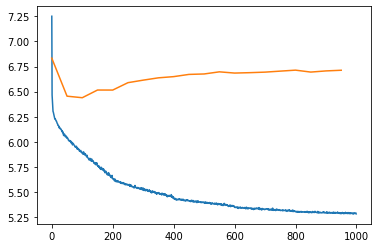

In [184]:
from tqdm import tqdm
import matplotlib.pyplot as plt

try:
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4, nesterov=True)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, gamma=0.5, milestones=[200,400,600,800])
    n_epochs = 1000

    train_losses = []
    val_losses = []
    for epoch in tqdm(range(n_epochs)):
        l_tot = 0
        num_batch = 0
        for X, y, _ in train_dataloader:
            X, y = X.cuda(), y.cuda()
            preds = model(X.double())
            l = delay_loss(preds, y, loss, video_shft)
            #print('training loss:', l)
            l_tot += l.item()
            l.backward()
            optimizer.step()
            optimizer.zero_grad()
            num_batch += 1
        scheduler.step()
        train_losses.append(l_tot/num_batch)   
        
        if epoch % (n_epochs//20) == 0:   
            model.eval()         
            l_val_tot = 0
            num_val_batch = 0
            for X_val, y_val, _ in test_dataloader:
                X_val, y_val = X_val.cuda(), y_val.cuda()
                preds_val = model(X_val.double())
                l_val = delay_loss(preds_val, y_val, loss, video_shft)
                l_val_tot += l_val.item()
                num_val_batch += 1

            val_losses.append(l_val_tot/num_val_batch)    
            #scheduler.step(l_val_tot/num_val_batch)

            print('epoch: ', epoch)
            print('training loss:', l_tot/num_batch)   
            print('validation loss:', l_val_tot/num_val_batch)
            model.train()
 
finally:
    fig, ax = plt.subplots()
    ax.plot(train_losses)
    ax.plot(list(range(0, len(val_losses) * (n_epochs//20), (n_epochs//20))), val_losses)
    plt.savefig(f'losses_{n_epochs}.png')            

In [145]:
model.eval()
all_data = FacePredictDataset(audio_data, lips_upsampled, video_shft, video_start, 1)
test_dataloader = DataLoader(all_data, batch_size = 1)
#test_dataloader = DataLoader(test_data, batch_size=300, shuffle=True)
X_val, y_val, val_starts = test_dataloader.__iter__().next()
X_val, y_val = X_val.cuda(), y_val.cuda()
preds_val = model(X_val.double())
sample_pred = preds_val.detach().cpu().numpy()[:, video_shft:].reshape(-1, 20)
sample_lips = pca.inverse_transform(sample_pred)
true_lips = pca.inverse_transform(y_val.cpu().reshape(-1, 20))
print((val_starts)*30/100 + 12)
print(sample_pred.shape)

tensor([ 8615.0996,  1150.5000,  2843.3999, 15168.9004,  3783.8999, 15386.7002,
        11624.7002,  2041.5000, 15911.4004,  6753.8999,  8288.4004, 11179.2002,
         7367.7002, 16762.8008,   843.6000,  5961.8999,  8120.1001,  3229.5000,
        14723.4004, 10713.9004,   685.2000,  5664.8999, 11278.2002, 14040.2998,
        16198.5000,  2754.3000, 13614.5996,  8308.2002,  4417.5000, 16436.0996,
         8783.4004,  3328.5000, 16663.8008, 14000.7002, 10466.4004,  4585.7998,
         6892.5000,  1506.9000, 13624.5000, 15505.5000, 16406.4004,  9397.2002,
         3269.1001,  9714.0000,  1546.5000, 12198.9004, 15109.5000, 14367.0000,
         7070.7002, 13347.2998,  9882.2998,  5219.3999,  3090.8999,  6377.7002,
         6843.0000,  3041.3999,  3655.2000,  2942.3999,  6011.3999,  7486.5000,
        11149.5000,  6991.5000,  4397.7002,  6150.0000,  9793.2002,  8436.9004,
         5427.2998,  5011.5000,   625.8000,  6961.7998,  3516.6001, 13278.0000,
         2170.2000, 14911.5000,  2229.60

In [146]:
#downsample predictions to 30 fps
preds_timess = [np.arange(video_start + val_st, video_start + val_st + data.crop_len) / 100 for val_st in val_starts]
downsample_timess = [np.arange(int(min(preds_t) * 30) + 1, int(max(preds_t) * 30)) / 30 for preds_t in preds_timess]
preds_times = np.concatenate(preds_timess)
downsample_times = np.concatenate(downsample_timess)

print(preds_times.shape, sample_lips.shape)
preds_interpolate = interp1d(preds_times, sample_lips, axis = 0)
downsample_preds = preds_interpolate(downsample_times)

true_interpolate = interp1d(preds_times, true_lips, axis = 0)
downsample_true = true_interpolate(downsample_times)

print(min(downsample_times)*30, max(downsample_times)*30)
print(downsample_preds.shape)

(9900,) (9900, 36)
32.0 16771.0
(2578, 36)


In [147]:
np.save('/content/drive/MyDrive/6869/sample_lips', sample_lips)
np.save('/content/drive/MyDrive/6869/downsample_preds', downsample_preds)
np.save('/content/drive/MyDrive/6869/downsample_true', downsample_true)
np.save('/content/drive/MyDrive/6869/downsample_times', downsample_times)

import pandas as pd
pd.DataFrame(sample_lips).to_csv('/content/drive/MyDrive/6869/sample_lips.csv', sep=' ', index=False, header=False)
pd.DataFrame(downsample_preds).to_csv('/content/drive/MyDrive/6869/downsample_preds.csv', sep=' ', index=False, header=False)